In [75]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [87]:
#Load dataset
df = pd.read_csv('USD_NGN Historical Data.csv')

df.head

<bound method NDFrame.head of          Date     Price      Open      High       Low Change %
0    1/5/2025  1,600.63  1,602.07  1,613.57  1,596.70   -0.11%
1    1/4/2025  1,602.39  1,537.73  1,644.01  1,526.50    4.20%
2    1/3/2025  1,537.77  1,499.07  1,560.00  1,491.34    2.31%
3    1/2/2025  1,503.00  1,481.00  1,552.50  1,442.50    1.49%
4    1/1/2025  1,481.00  1,538.57  1,575.50  1,442.50   -3.46%
..        ...       ...       ...       ...       ...      ...
119  1/6/2015    198.98       199    199.24    195.05   -0.01%
120  1/5/2015       199    198.05    199.45    198.05    0.51%
121  1/4/2015       198    199.05     199.1    198.05   -0.50%
122  1/3/2015       199    202.55    202.55    195.05   -1.73%
123  1/2/2015     202.5     190.5     206.1    187.55    8.00%

[124 rows x 6 columns]>

In [88]:
#View the columns
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Change %'], dtype='object')

In [89]:
#Check the date types
df.dtypes

Date        object
Price       object
Open        object
High        object
Low         object
Change %    object
dtype: object

In [90]:
#I want the datatypes to be a float
cols_to_clean = ['Price', 'Open', 'High', 'Low', 'Change %']

for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(',', '').str.replace('%', '').astype(float)


In [91]:
#Rechecking the data types
df.dtypes

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Change %    float64
dtype: object

In [92]:
#Check for missing values
print(df.isnull().sum())

Date        0
Price       0
Open        0
High        0
Low         0
Change %    0
dtype: int64


In [94]:
#I want to use the data and price columns, so i am dropping the rest
df = df[['Date', 'Price']]

In [95]:
#Sort by date
df = df.sort_values('Date').reset_index(drop=True)

In [96]:
#Create lag features to captures prices from previous days
for lag in range(1,4):
    df[f'lag_{lag}'] = df['Price'].shift(lag)

In [97]:
#Calculate moving averages to smooth out short term price noise
df['ma_3'] = df['Price'].rolling(window=3).mean()
df['ma_7'] = df['Price'].rolling(window=7).mean()

In [99]:
#Define the target variable
df['target'] = df['Price'].shift(-1)

In [100]:
#Drop rows with NaNs
df = df.dropna().reset_index(drop=True)

In [101]:
#Split the data into training(80%) and testing (20%) 
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

In [103]:
#Select all lag features + moving averages
feature_cols = [col for col in df.columns if col.startswith('lag_')] + ['ma_3', 'ma_7']

In [104]:
#Creating feature matrices and target vertors for train and test
X_train, y_train = train_df[feature_cols], train_df['target']
X_test, y_test = test_df[feature_cols], test_df['target']

In [105]:
#Training the model
#Initialize XGBoost regressor with sensible hyperparameters
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [106]:
#Using trained model to predict prices on the test set
y_pred = model.predict(X_test)

In [118]:
#Calculate mean absolute error to quantify average prediciton error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error on Test Set:", round(mae, 2))

Mean Absolute Error on Test Set: 20.39


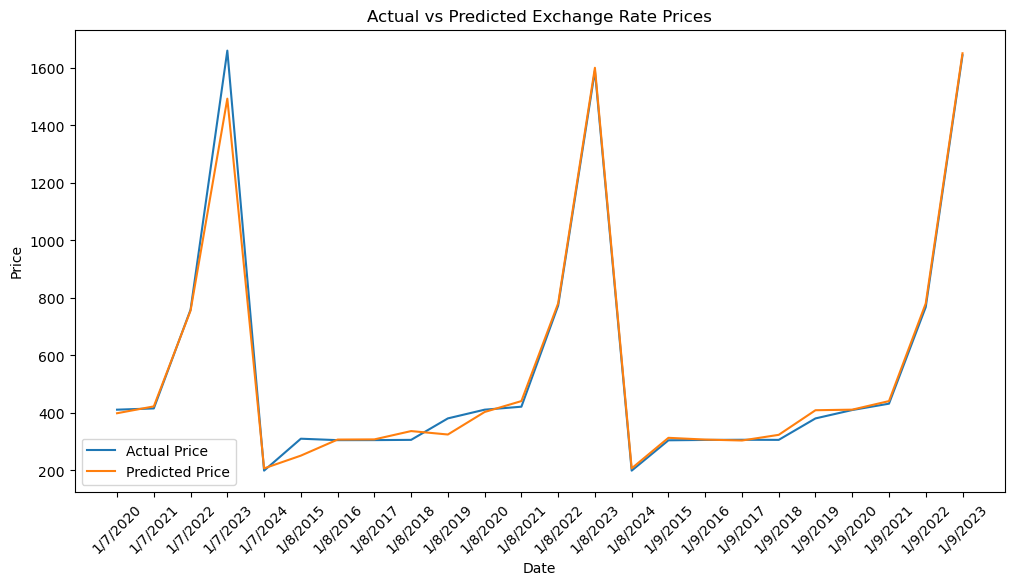

In [135]:
#Visulaizing the model
plt.figure(figsize=(12,6))
plt.xticks(rotation=45) 
plt.plot(test_df['Date'], y_test, label='Actual Price')
plt.plot(test_df['Date'], y_pred, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Exchange Rate Prices')
plt.legend()
plt.show()


In [130]:
results = pd.DataFrame({  
    'Date': df['Date'].iloc[split_index:],
    'Actual Price' : y_test,
    'Predicted Price' : y_pred 
})

print(results)

         Date  Actual Price  Predicted Price
93   1/7/2020        411.00       398.602509
94   1/7/2021        415.37       422.442444
95   1/7/2022        758.90       755.732178
96   1/7/2023       1660.00      1492.875732
97   1/7/2024        199.00       206.873016
98   1/8/2015        310.00       251.141220
99   1/8/2016        305.00       307.014923
100  1/8/2017        305.15       307.615356
101  1/8/2018        306.00       336.550446
102  1/8/2019        380.70       324.632996
103  1/8/2020        411.00       402.968323
104  1/8/2021        421.38       440.888092
105  1/8/2022        773.00       780.940674
106  1/8/2023       1590.00      1600.336914
107  1/8/2024        198.98       206.873016
108  1/9/2015        304.50       313.101257
109  1/9/2016        305.75       307.014923
110  1/9/2017        306.35       303.757263
111  1/9/2018        305.95       323.488678
112  1/9/2019        380.60       409.074219
113  1/9/2020        409.80       411.078674
114  1/9/2